# AFLP API 50 CH

## Libraries

In [ ]:
import  nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [ ]:
import os, sys
import pandas as pd
import numpy as np

sys.path.append(os.path.join(os.getcwd(), "Code"))
from dataset import generate_dataset
from feature_selection import find_best_parameters
from model_training import train, plot_performance
from gene_ranking import calculate_gene_families, download_stop_words

## Dataset

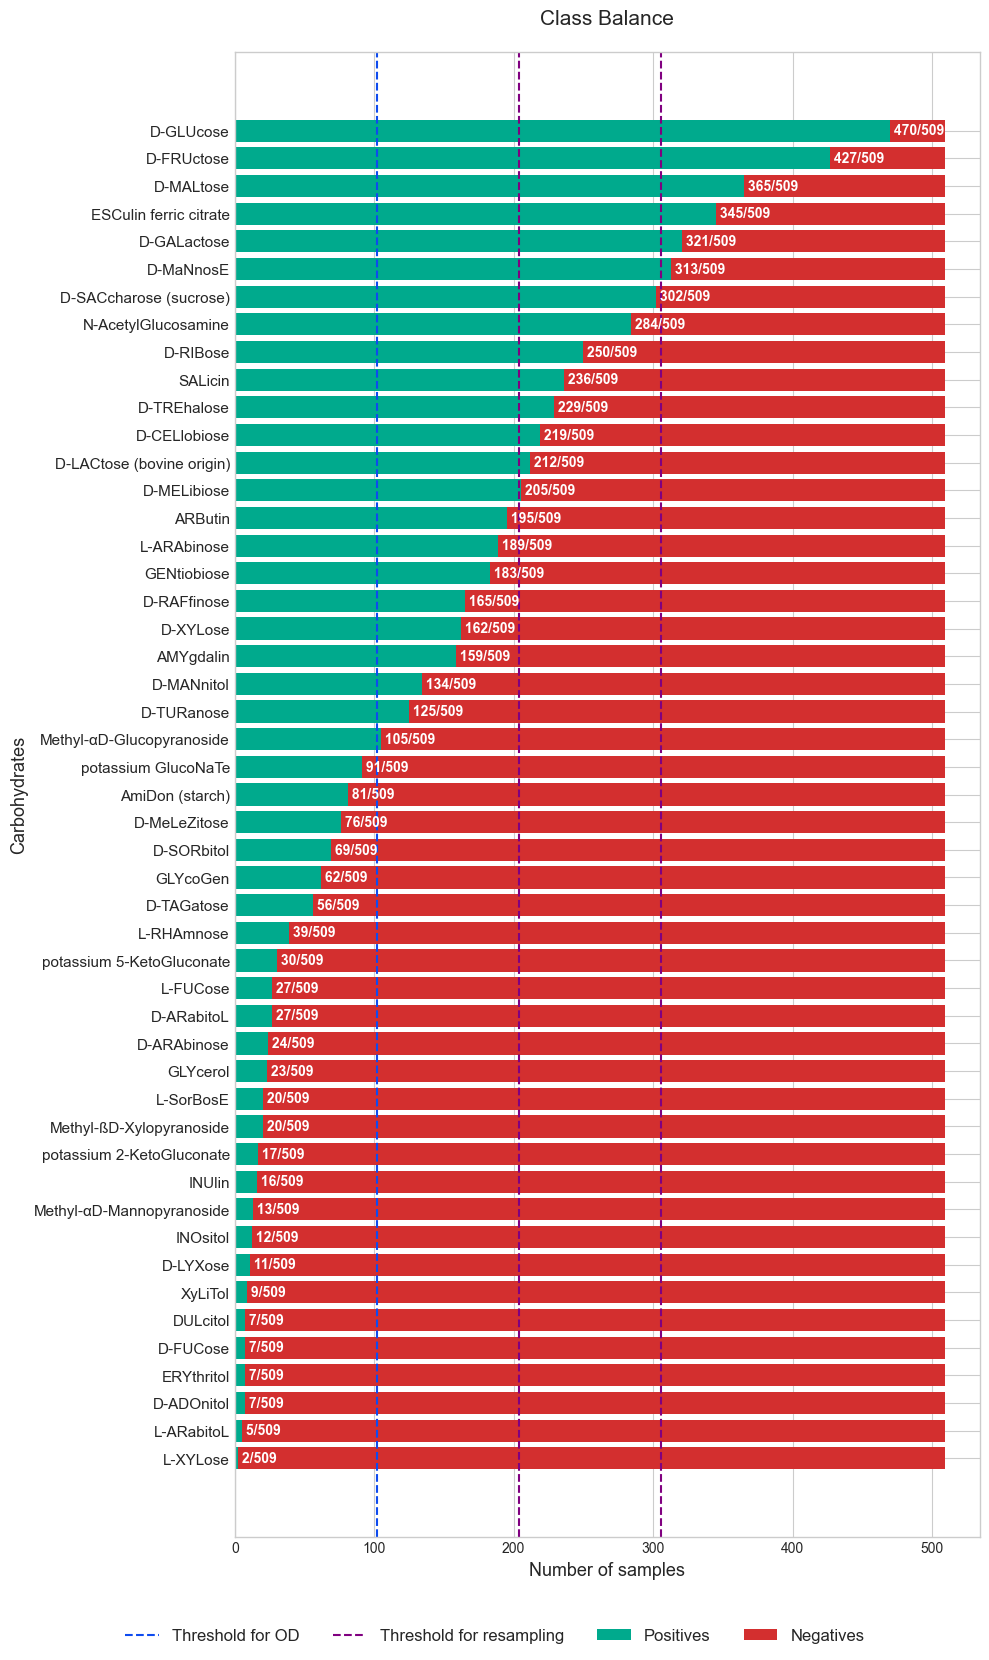

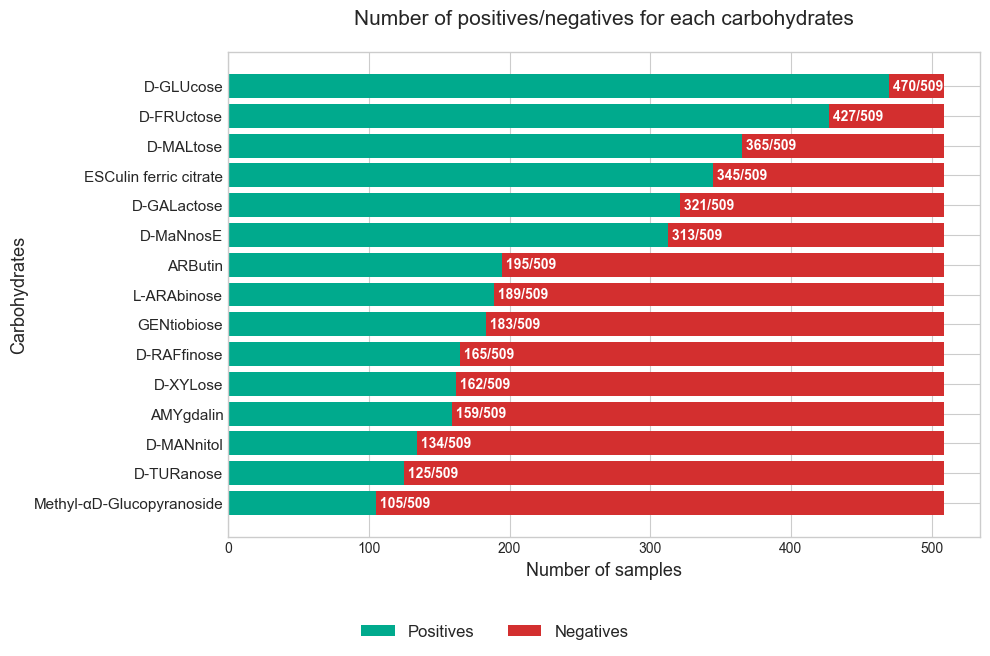

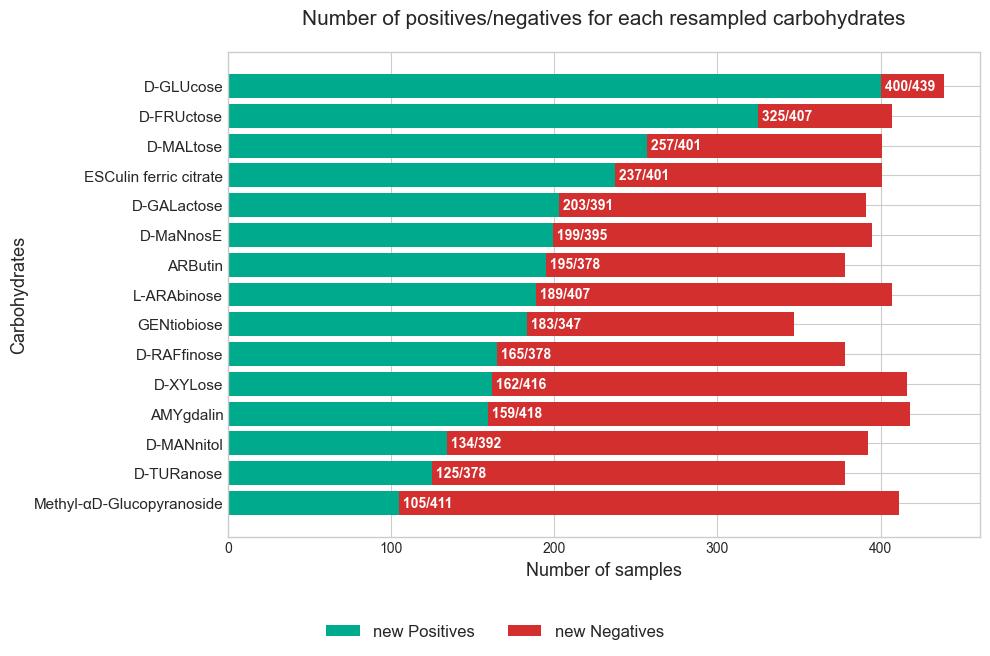

In [ ]:
dataset_folder = "Data/"
threshold_rebalance = 0.4      # Used for under-sampling
threshold_OD = 0.2             # Used for outlier Detection: lower then 20%
draw = True

dataset = generate_dataset(dataset_folder, draw, threshold_rebalance, threshold_OD)

balanced_dataset = dataset['balanced']
semibalanced_dataset = dataset['semibalanced']
unbalanced_dataset = dataset['unbalanced']

## Training

### Training with only Random Forest

In [ ]:
balanced_performance, balanced_models           = train(balanced_dataset, dataset_type='balanced')
semibalanced_performance, semibalanced_models   = train(semibalanced_dataset, dataset_type='semibalanced')
unbalanced_performance, unbalanced_models       = train(unbalanced_dataset, dataset_type='unbalanced')

performance_rf = pd.concat([balanced_performance, semibalanced_performance, unbalanced_performance], ignore_index=True).set_index('Carbohydrates')

display(performance_rf)

### Training with feature selection and Random Forest or Decisional Tree

In [ ]:
param_grid = {
    'pos_sensibility': [0.5, 0.55, 0.7],
    'neg_sensibility': [0.85],
    'k': [380],
    'estimators': [8, 24, 32, 64]
}

param_grid_unbalanced = {
    'pos_sensibility': [0.65, 0.5, 0.8],
    'neg_sensibility': [0.5],
    'k': [35, 50, 140],
    'estimators': [0]
}

balanced_performance_fs     = find_best_parameters(balanced_dataset, param_grid, dataset_type='balanced')
semibalanced_performance_fs = find_best_parameters(semibalanced_dataset, param_grid, dataset_type='semibalanced')
unbalanced_performance_fs   = find_best_parameters(unbalanced_dataset, param_grid, dataset_type='unbalanced')

performance_fs = pd.concat([balanced_performance_fs, semibalanced_performance_fs, unbalanced_performance_fs], ignore_index=True).set_index('Carbohydrates')

with pd.ExcelWriter("Result/Performance/performance_fs.xlsx") as writer:
    performance_fs.to_excel(writer, index=False)

## Visualize performances

### Find best models

In [ ]:
# Read performances files
balanced_performance = pd.read_excel('./Result/Performance/performance_balanced.xlsx')
semibalanced_performance = pd.read_excel('./Result/Performance/performance_semibalanced.xlsx')
unbalanced_performance_fs = pd.read_excel('./Result/Performance/performance_fs_unbalanced.xlsx')
unbalanced_performance_fs['Model'] = 'DT-FS'

performance = pd.concat([balanced_performance, semibalanced_performance, unbalanced_performance_fs], ignore_index=True).set_index("Carbohydrates")

with pd.ExcelWriter("Result/Performance/performance.xlsx") as writer:
    performance.to_excel(writer, index=True)


### Plot general performances

In [ ]:
performance = pd.read_excel("Result/Performance/performance.xlsx").set_index("Carbohydrates")

##### Balanced and semibalanced carbohydrates

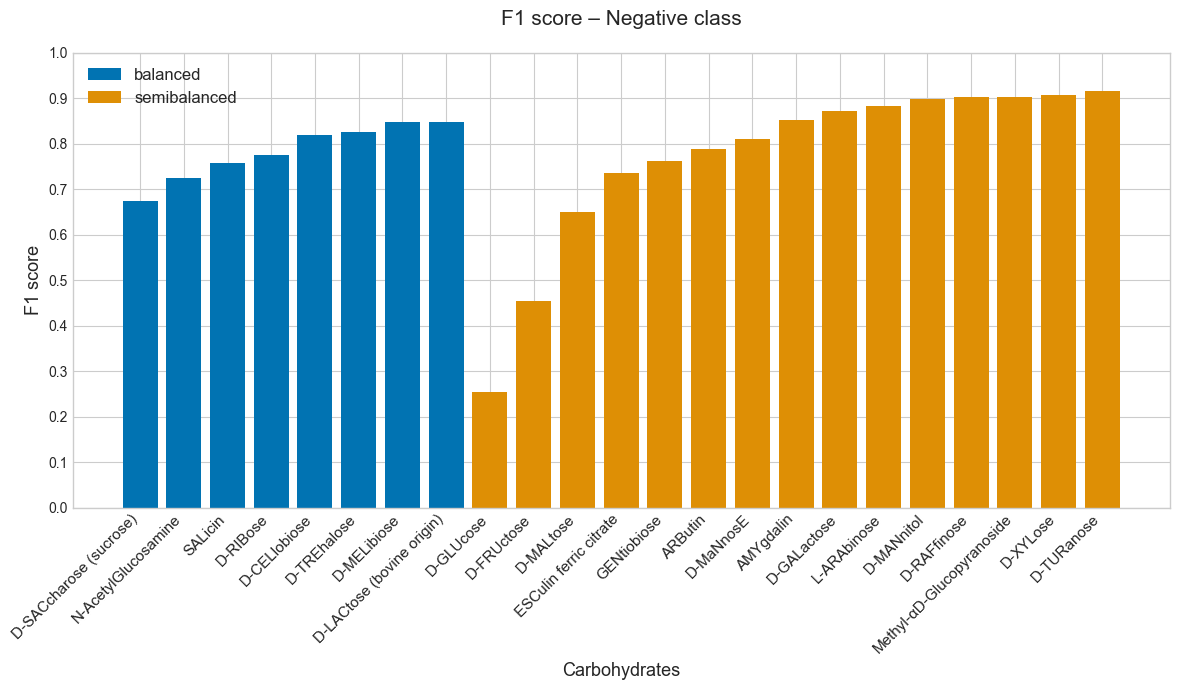

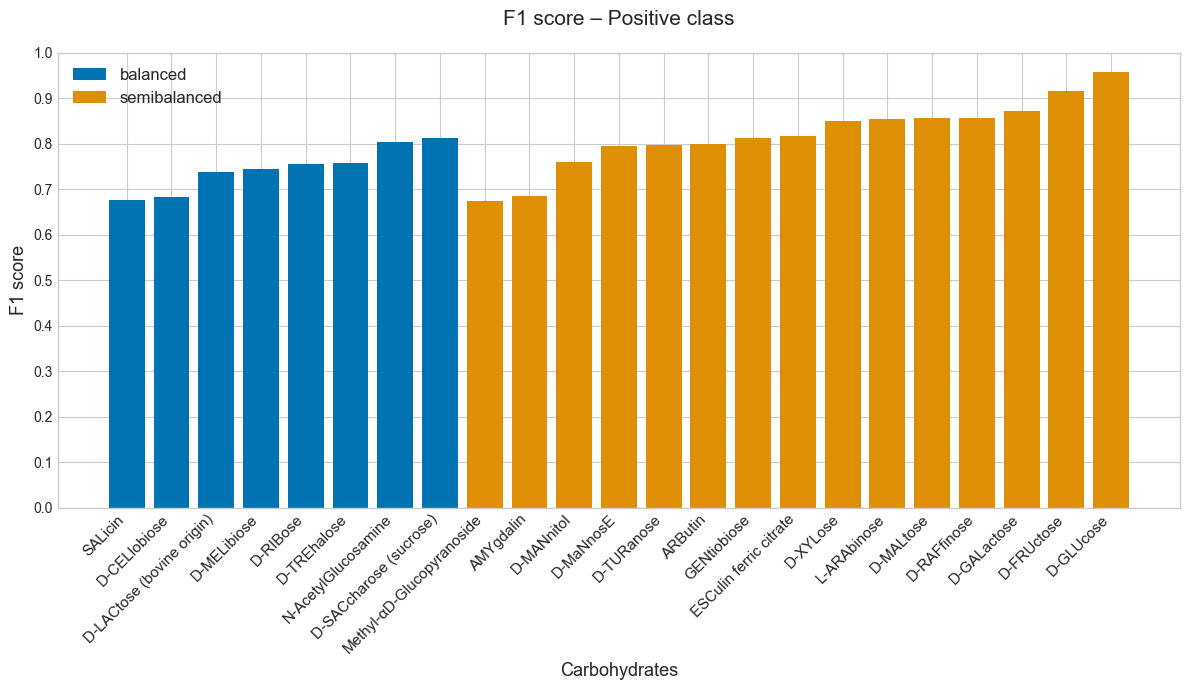

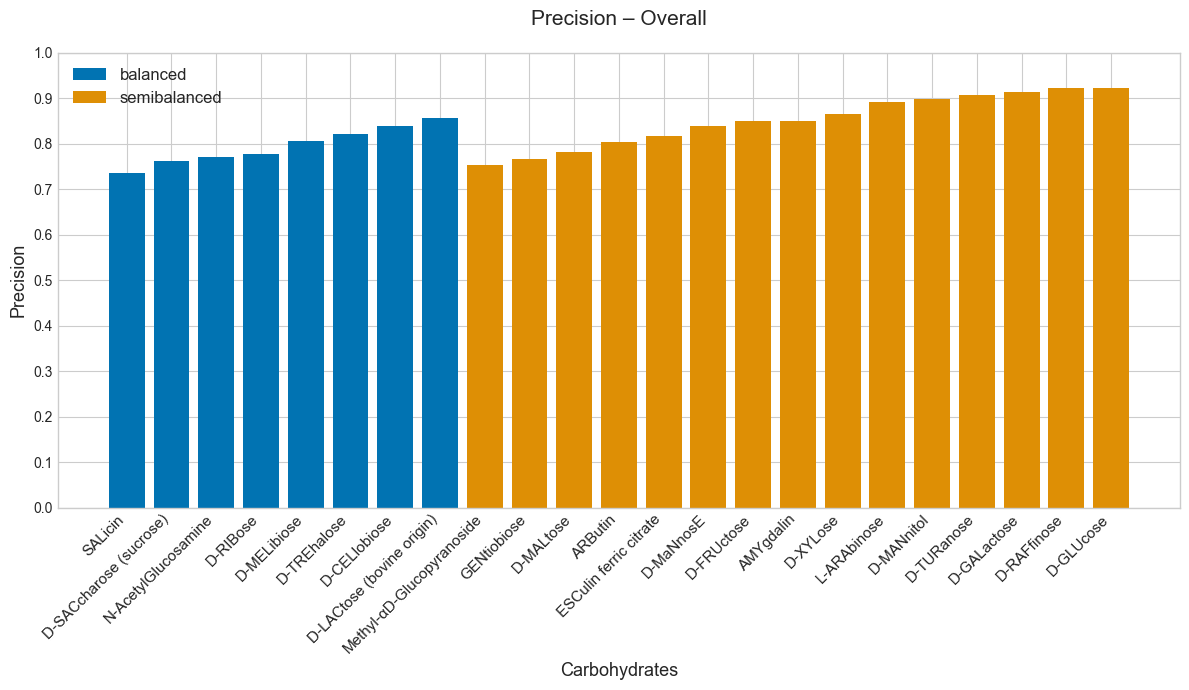

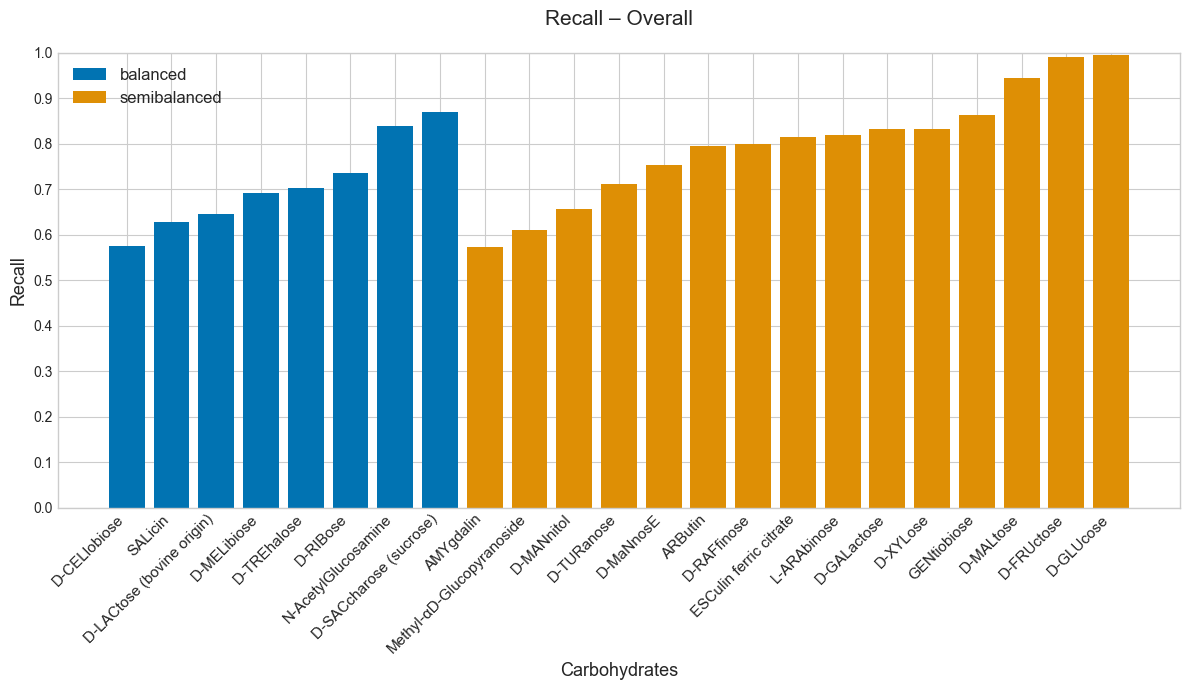

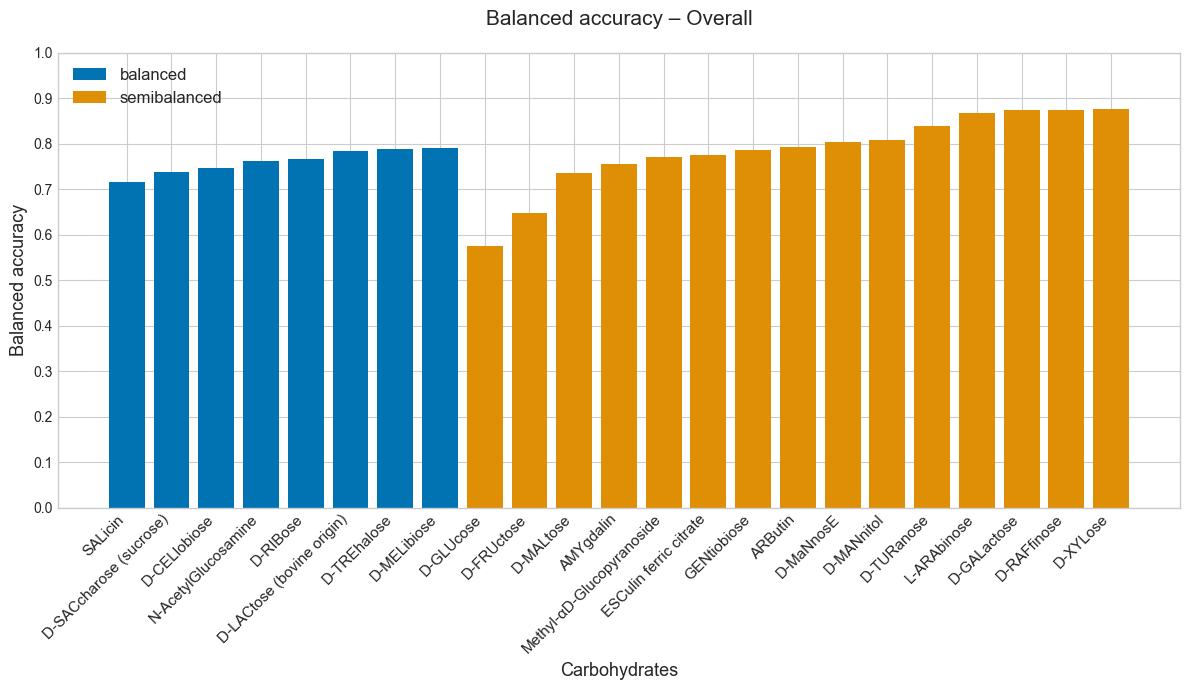

In [ ]:
pb = performance[performance['Dataset type'] == 'balanced']
psb = performance[performance['Dataset type'] == 'semibalanced']

performance_rf = pd.concat([pb, psb], axis=0).sort_values(['Dataset type'])

plot_performance(performance_rf.sort_values(by=["Dataset type", "F1 score class 0"]), file_name='performance_rf_class_0', metric='F1 score class 0', title='F1 score – Negative class')
plot_performance(performance_rf.sort_values(by=["Dataset type", "F1 score class 1"]), file_name='performance_rf_class_1', metric='F1 score class 1', title='F1 score – Positive class')
plot_performance(performance_rf.sort_values(by=["Dataset type", "Precision"]), file_name='performance_rf_precision', metric='Precision', title='Precision – Overall')
plot_performance(performance_rf.sort_values(by=["Dataset type", "Recall"]), file_name='performance_rf_recall', metric='Recall', title='Recall – Overall')
plot_performance(performance_rf.sort_values(by=["Dataset type", "Balanced accuracy"]), file_name='performance_rf_accuracy', metric='Balanced accuracy', title='Balanced accuracy – Overall')

##### Unbalanced carbohydrates

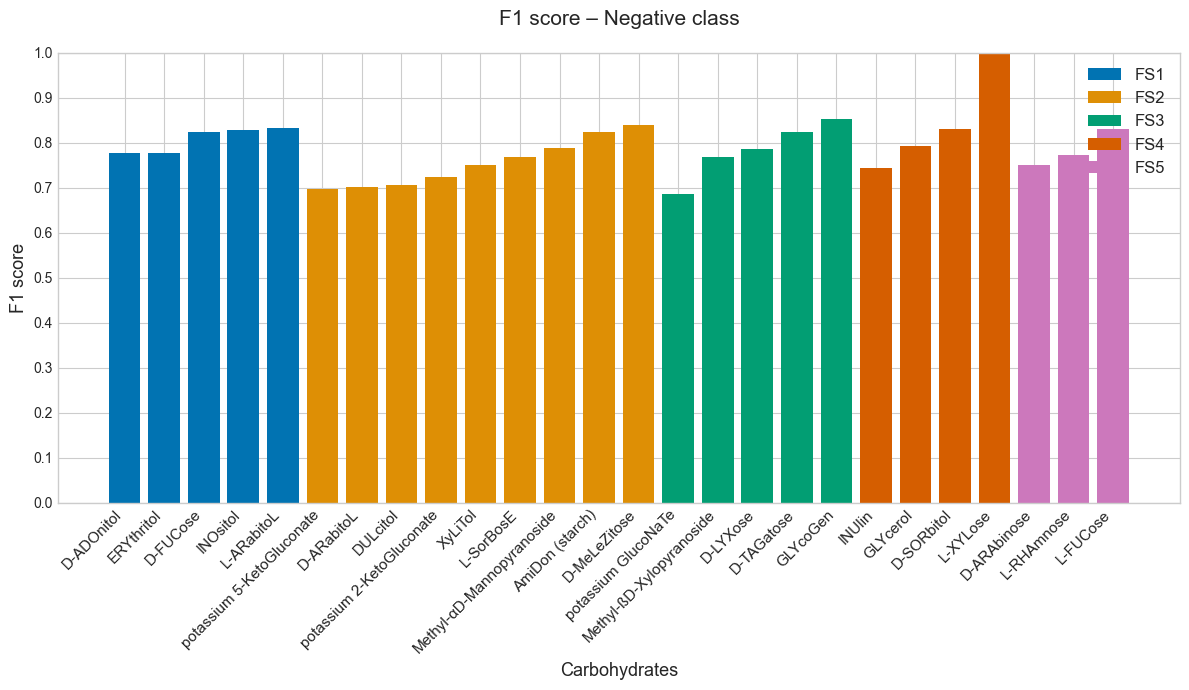

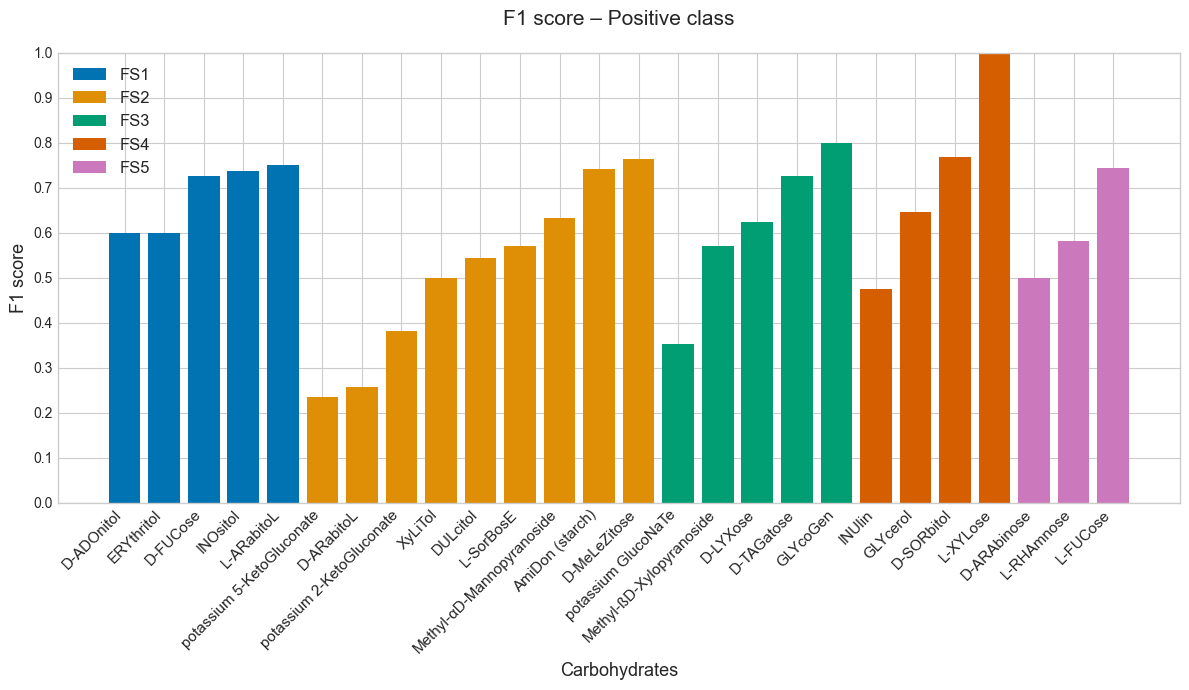

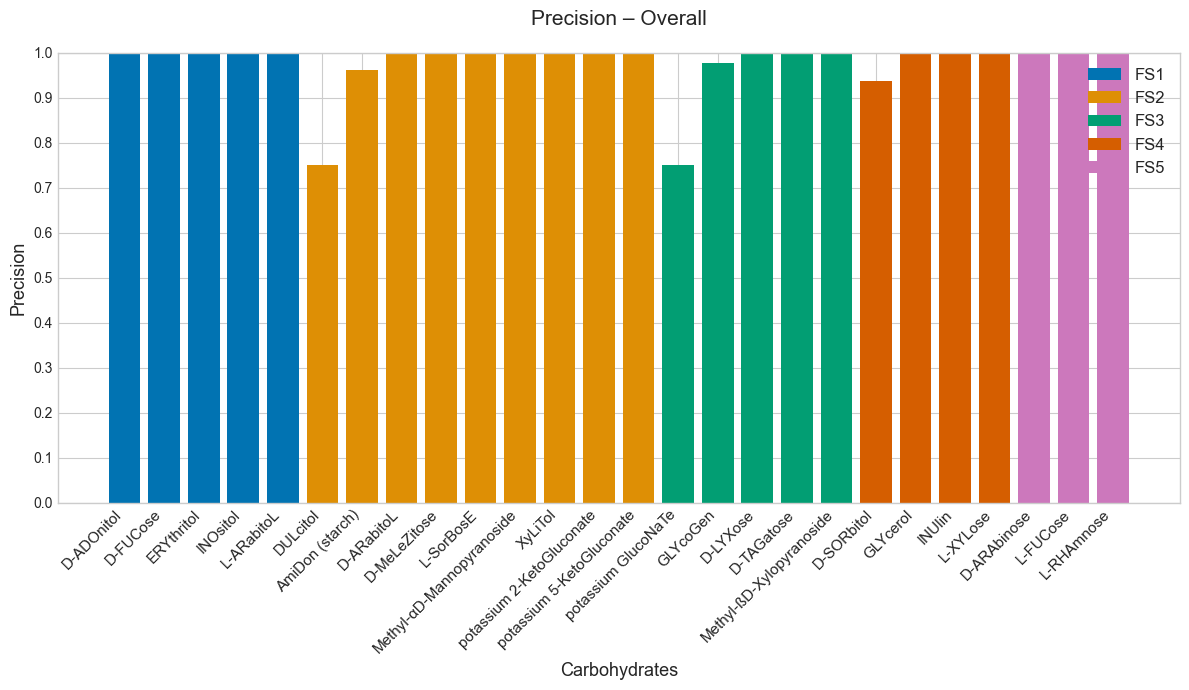

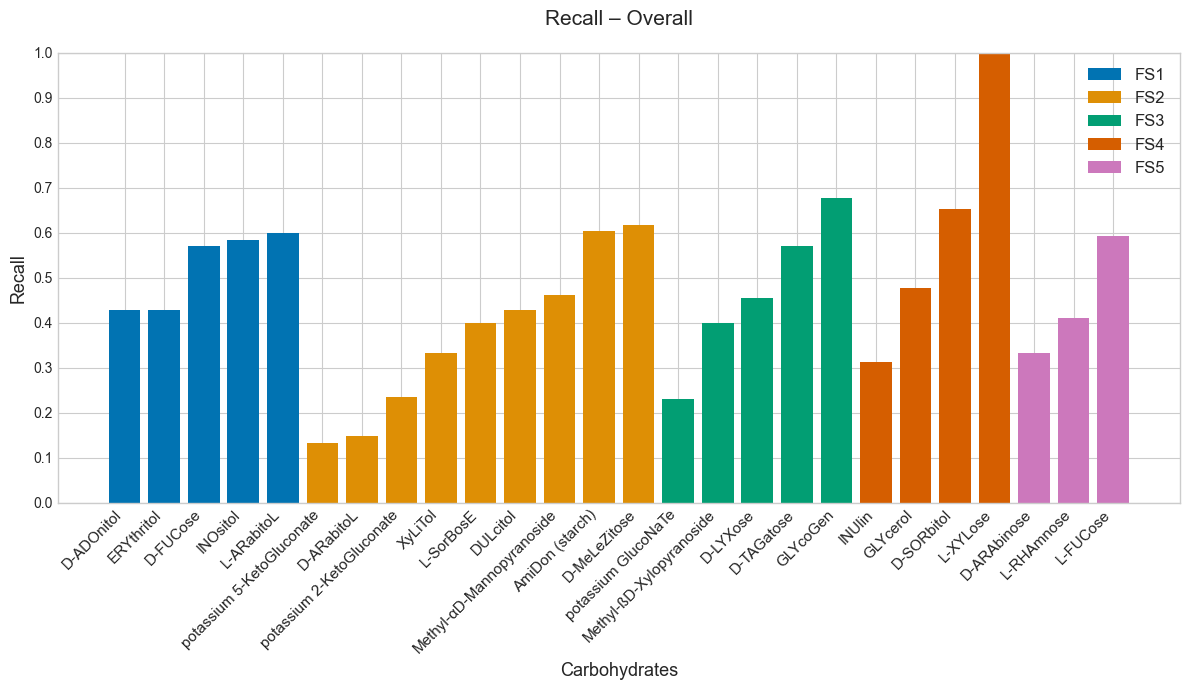

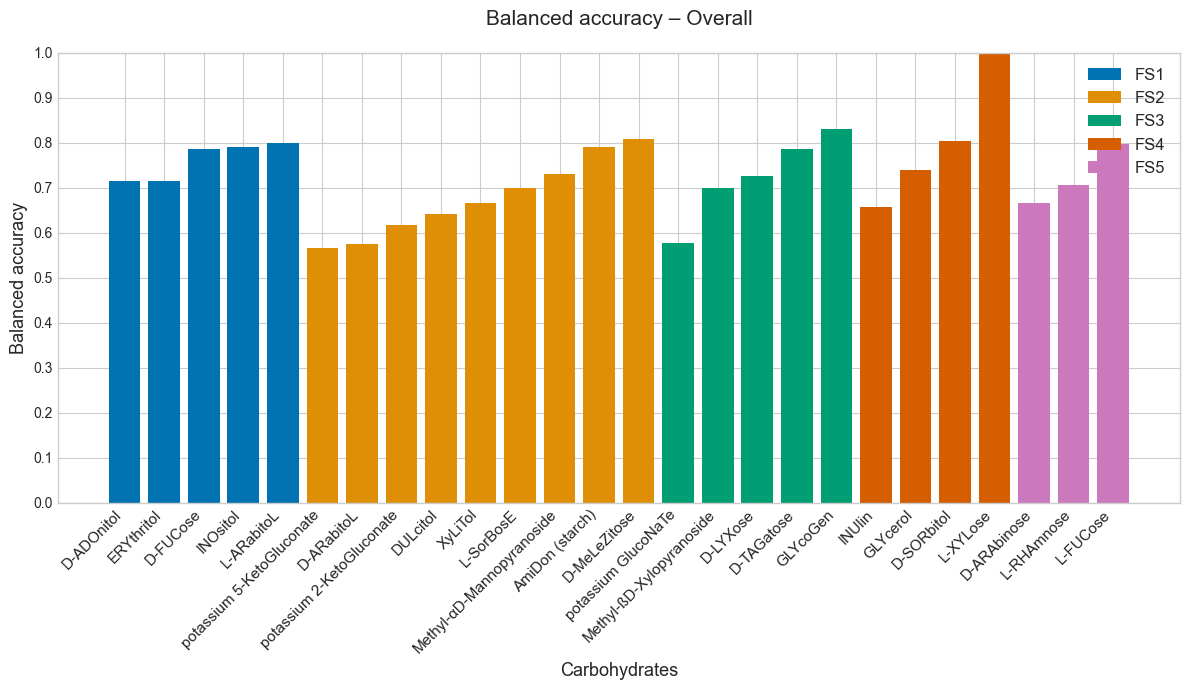

In [ ]:
pub_fs = performance[performance['Model'] == 'DT-FS']
performance_ub = pub_fs
performance_ub["Dataset type"] = performance["Dataset type"].str.split().str[-1]

plot_performance(performance_ub.sort_values(by=["Dataset type", "F1 score class 0"]), file_name='performance_fs_class_0', metric='F1 score class 0', title='F1 score – Negative class')
plot_performance(performance_ub.sort_values(by=["Dataset type", "F1 score class 1"]), file_name='performance_fs_class_1', metric='F1 score class 1', title='F1 score – Positive class')
plot_performance(performance_ub.sort_values(by=["Dataset type", "Precision"]), file_name='performance_fs_precision', metric='Precision', title='Precision – Overall')
plot_performance(performance_ub.sort_values(by=["Dataset type", "Recall"]), file_name='performance_fs_recall', metric='Recall', title='Recall – Overall')
plot_performance(performance_ub.sort_values(by=["Dataset type", "Balanced accuracy"]), file_name='performance_fs_accuracy', metric='Balanced accuracy', title='Balanced accuracy – Overall')

##### All carbohydrates

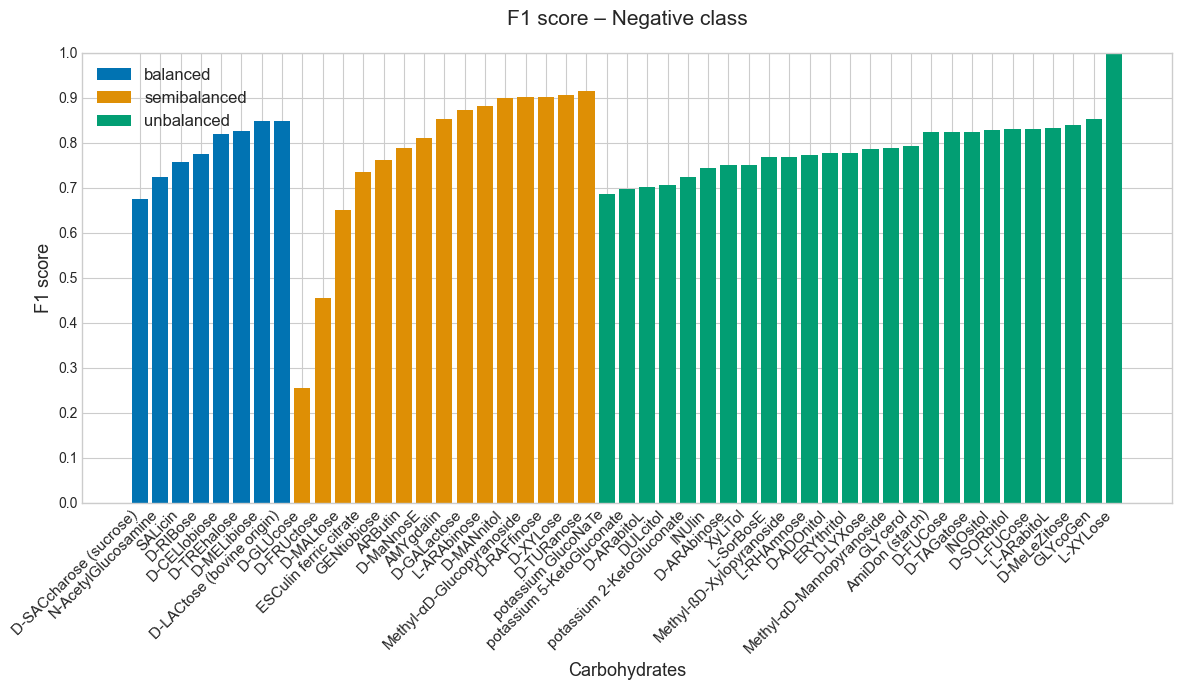

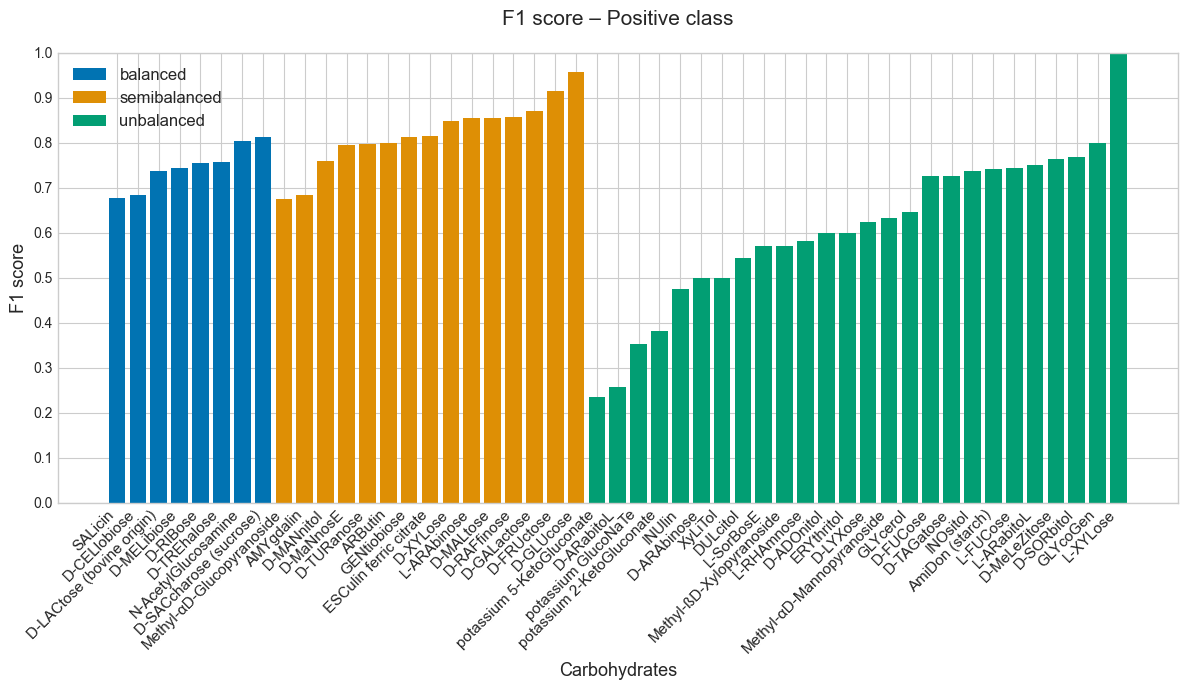

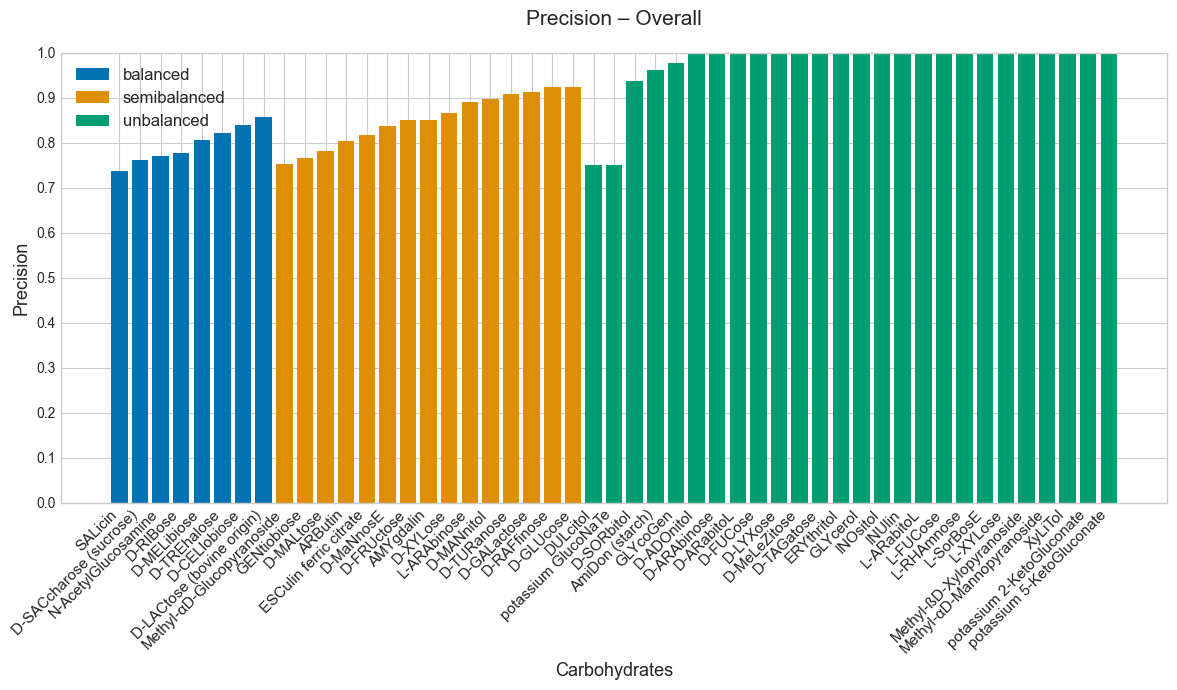

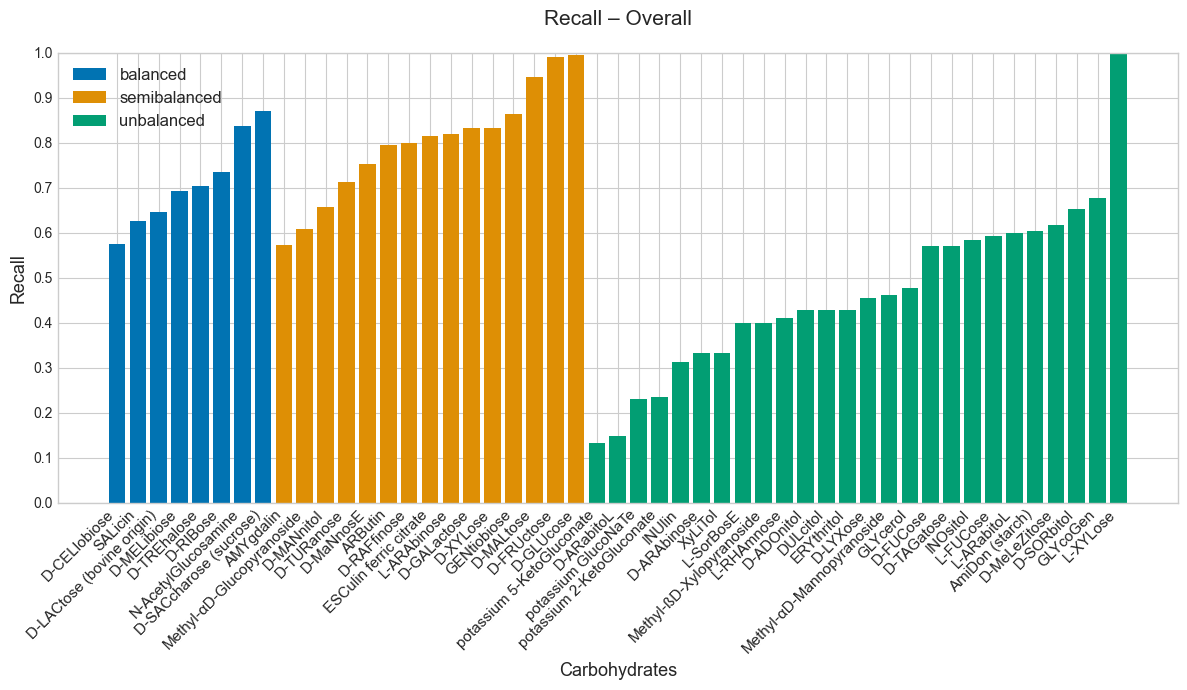

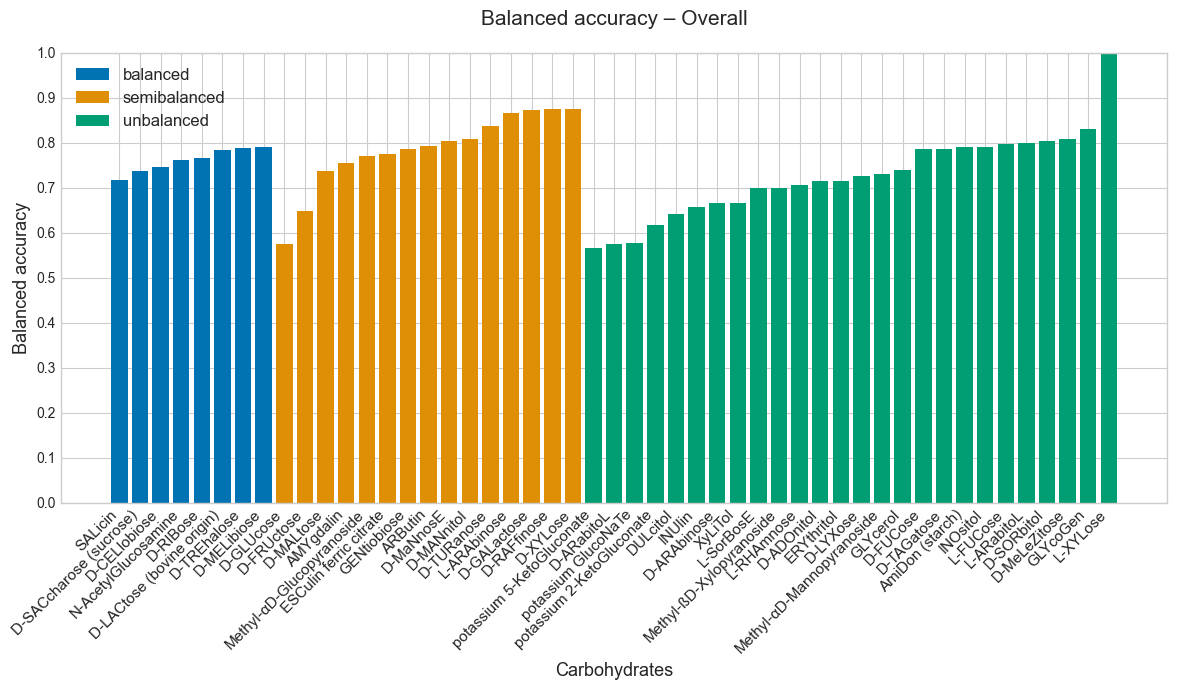

In [17]:
conditions = [
    performance['Dataset type'].str.startswith("balanced"),
    performance['Dataset type'].str.startswith("semibalanced"),
    performance['Dataset type'].str.startswith("unbalanced")
]

choices = ["balanced", "semibalanced", "unbalanced"]
performance['Dataset type'] = np.select(conditions, choices, default=performance['Dataset type'])

plot_performance(performance.sort_values(by=["Dataset type", "F1 score class 0"]), file_name='performance_class_0', metric='F1 score class 0', title='F1 score – Negative class')
plot_performance(performance.sort_values(by=["Dataset type", "F1 score class 1"]), file_name='performance_class_1', metric='F1 score class 1', title='F1 score – Positive class')
plot_performance(performance.sort_values(by=["Dataset type", "Precision"]), file_name='performance_precision', metric='Precision', title='Precision – Overall')
plot_performance(performance.sort_values(by=["Dataset type", "Recall"]), file_name='performance_recall', metric='Recall', title='Recall – Overall')
plot_performance(performance.sort_values(by=["Dataset type", "Balanced accuracy"]), file_name='performance_accuracy', metric='Balanced accuracy', title='Balanced accuracy – Overall')

with pd.ExcelWriter('./Result/Performance/performance.xlsx') as writer:
    performance.to_excel(writer, index=True)

## Calculate gene importances

In [ ]:
calculate_gene_families()

Calculate feature importances.
[OFF] Processes strain coverage based on the feature importances.
Analyzes gene families to evaluate their importances.
	Calculating common genes for carbohydrate D-MELibiose:	 	Calculating common genes for carbohydrate potassium 5-KetoGluconate:	 	Calculating common genes for carbohydrate L-XYLose:	 	Calculating common genes for carbohydrate D-MANnitol:	 	Calculating common genes for carbohydrate D-MaNnosE:	 	Calculating common genes for carbohydrate .DS_Store:	 	Calculating common genes for carbohydrate ARButin:	 	Calculating common genes for carbohydrate potassium 2-KetoGluconate:	 	Calculating common genes for carbohydrate D-RAFfinose:	 	Calculating common genes for carbohydrate D-CELlobiose:	 	Calculating common genes for carbohydrate D-FRUctose:	 	Calculating common genes for carbohydrate D-RIBose:	 	Calculating common genes for carbohydrate D-ADOnitol:	 	Calculating common genes for carbohydrate L-ARAbinose:	 	Calculating common genes for carbohydr